# code

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
os.listdir('/kaggle/input/resnet-152-4')

['cp-0029.ckpt.data-00000-of-00001', 'cp-0029.ckpt.index', 'checkpoint']

In [65]:

LABELS_PATH = "/kaggle/input/birds23sp/birds/labels.csv"
TEST_PATH = "/kaggle/input/birds23sp/birds/test"
TRAIN_PATH = "/kaggle/input/birds23sp/birds/train"
# LABELS_PATH = "/content/birds/labels.csv"
# TEST_PATH = "/content/birds/test"
# TRAIN_PATH = "/content/birds/train"
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

<Figure size 640x480 with 0 Axes>

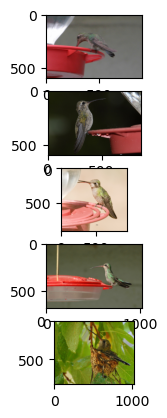

In [6]:
explore_data_path = os.path.join(TRAIN_PATH, '437')
files = os.listdir(explore_data_path)
plt.figure()
_, ax = plt.subplots(5)
for ind, file in enumerate(files):
    if ind >= 5: break    
    file_path = os.path.join(explore_data_path, file)
    ax[ind].imshow(np.array(Image.open(file_path)))

In [66]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAIN_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=455)
# test_dataset = tf.keras.utils.image_dataset_from_directory(TEST_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

Found 38562 files belonging to 555 classes.


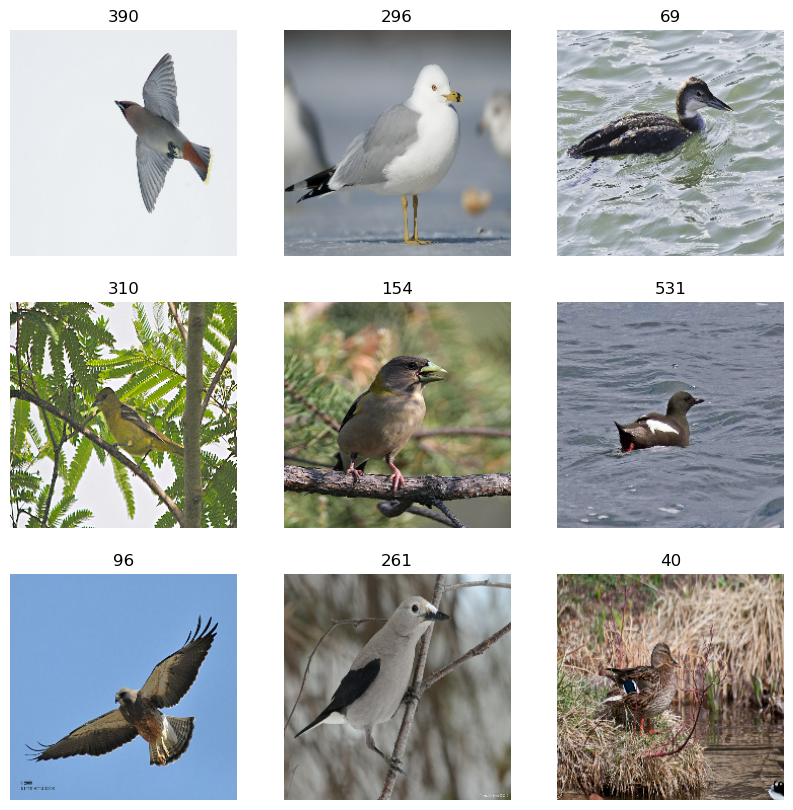

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [67]:
# make a vaiation set consiting of 20% of the training set
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)

In [68]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [69]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# preprocess_input = tf.keras.applications.resnet50.preprocess_input
# preprocess_input = tf.keras.applications.vgg19.preprocess_input
# preprocess_input = tf.keras.applications.resnet.preprocess_input
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [70]:
IMG_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')


In [ ]:
# or, use resnet
# base_model = tf.keras.applications.resnet50.ResNet50(
#     input_shape=IMG_SHAPE,
#     weights='imagenet',
#     include_top=False)

In [ ]:
# or, use vgg19
# base_model = tf.keras.applications.vgg19.VGG19(
#     input_shape=IMG_SHAPE,
#     weights='imagenet',
#     include_top=False)

In [13]:
# # or, use resnet152
# base_model = tf.keras.applications.resnet.ResNet152(
#     input_shape=IMG_SHAPE,
#     weights='imagenet',
#     include_top=False)

234698864/234698864 [==============================] - 1s 0us/step


In [61]:
# efficient net v2
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
#     input_shape=IMG_SHAPE,
#     weights='imagenet',
#     include_top=False)
# efficient net v2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    input_shape=IMG_SHAPE,
    weights='imagenet',
    include_top=False)

82420632/82420632 [==============================] - 1s 0us/step


In [71]:
base_model.trainable = False

In [72]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [73]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)

In [74]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [75]:
# callback to save the model weights after each epoch
# checkpoint_path = "resnset50/cp-{epoch:04d}.ckpt"
# checkpoint_path = "/content/drive/MyDrive/455_checkpoints/resnet152_4/cp-{epoch:04d}.ckpt"
checkpoint_path = "./efnets/cp-{epoch:04d}.ckpt"
# load_checkpoint_dir = "/kaggle/input/resnet-152-4"

checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')


In [76]:
initial_epochs = 30

In [23]:
# model.load_weights('/kaggle/input/resnet-final/cp-0031.ckpt')

In [77]:
loss0, accuracy0 = model.evaluate(validation_dataset)

482/482 [==============================] - 46s 86ms/step - loss: 6.3397 - sparse_categorical_accuracy: 0.0014


In [78]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 6.34
initial accuracy: 0.00


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback],
                    initial_epoch=0)

Epoch 1/30
1929/1929 [==============================] - ETA: 0s - loss: 4.1101 - sparse_categorical_accuracy: 0.1958
Epoch 1: saving model to ./efnets/cp-0001.ckpt
1929/1929 [==============================] - 320s 142ms/step - loss: 4.1101 - sparse_categorical_accuracy: 0.1958 - val_loss: 2.8799 - val_sparse_categorical_accuracy: 0.3224
Epoch 2/30
1928/1929 [============================>.] - ETA: 0s - loss: 2.5961 - sparse_categorical_accuracy: 0.3836
Epoch 2: saving model to ./efnets/cp-0002.ckpt
1929/1929 [==============================] - 307s 142ms/step - loss: 2.5962 - sparse_categorical_accuracy: 0.3836 - val_loss: 2.3217 - val_sparse_categorical_accuracy: 0.4254
Epoch 3/30
1928/1929 [============================>.] - ETA: 0s - loss: 2.1673 - sparse_categorical_accuracy: 0.4674
Epoch 3: saving model to ./efnets/cp-0003.ckpt
1929/1929 [==============================] - 311s 144ms/step - loss: 2.1673 - sparse_categorical_accuracy: 0.4674 - val_loss: 2.0731 - val_sparse_categorical_

In [ ]:
history2 = model.fit(train_dataset,
                epochs=80,
                validation_data=validation_dataset,
                callbacks=[cp_callback],
                initial_epoch=20)

In [ ]:
model.evaluate(validation_dataset)

In [30]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TEST_PATH, shuffle=False, batch_size=32, image_size=IMAGE_SIZE)

Found 10000 files belonging to 1 classes.


In [31]:
paths = test_dataset.file_paths

In [32]:
# build an index to directory lookup table (for getting actual class name)
# class_lut = sorted(os.listdir("/kaggle/input/birds23sp/birds/train"))

oh my god the class names are all messed up..... The class names correspond to the 0-based index of where the folder appears in the train directory, not on the name of the folder itself.....

should be kinda easy to make a mapping but this is still very cringe

In [ ]:
preds = model.predict(validation_dataset)

In [ ]:
val_preds = preds

In [34]:
test_preds = model.predict(test_dataset)

313/313 [==============================] - 79s 252ms/step


In [35]:
# maxed_val_preds = np.argmax(val_preds, axis=1)
maxed_test_preds = np.argmax(test_preds, axis=1)

In [36]:
maxed_test_preds

array([473, 333, 422, ..., 521, 203,  97])

In [37]:
real_preds = []
for pred in maxed_test_preds:
    real_preds.append(int(class_names[pred]))

In [38]:
real_preds[:10]

[524, 399, 479, 516, 175, 143, 256, 252, 178, 156]

In [39]:
raw_paths = []
for path in paths:
    raw_paths.append('test/' + path.split('/')[-1])

In [40]:
output1 = pd.DataFrame({
    "path": raw_paths,
    "class": real_preds
})

In [41]:
output1[0:10]

,path,class
0,test/0000d9fc4e024c06a0afa55cfb16b12b.jpg,524
1,test/00085a7befcc4c08a83038477e749101.jpg,399
2,test/000ef8cc723046a08415e13eb13bbc28.jpg,479
3,test/0015c3c30eac4e9e823a6b1c120e565f.jpg,516
4,test/0017839359ef4637a4139fc829cd66fd.jpg,175
5,test/001b2009a40b4499aabc55a7b13bbab9.jpg,143
6,test/001b3efdd932452da06f70bd0d962b9c.jpg,256
7,test/001c81f1d30240298cb54488e966eff7.jpg,252
8,test/00209b86583c44d1b7efa7dcab6bed7d.jpg,178
9,test/0023153851eb40ba80a170e8e3239d13.jpg,156


In [42]:
output1.to_csv('aaaaa.csv', index=False)

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [27]:
# unfreeze some layers
base_model.trainable = True
for layer in base_model.layers[:450]:
  layer.trainable = False

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model.summary()

In [29]:
# fine tuning
history_fine = model.fit(train_dataset,
                         epochs=60,
                         initial_epoch=37,
                         callbacks=[cp_callback],
                         validation_data=validation_dataset)


Epoch 38/60
965/965 [==============================] - ETA: 0s - loss: 0.9904 - sparse_categorical_accuracy: 0.7161
Epoch 38: saving model to ./resnet152_5/cp-0038.ckpt
965/965 [==============================] - 288s 239ms/step - loss: 0.9904 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.6589 - val_sparse_categorical_accuracy: 0.5817
Epoch 39/60
964/965 [============================>.] - ETA: 0s - loss: 0.7254 - sparse_categorical_accuracy: 0.7883
Epoch 39: saving model to ./resnet152_5/cp-0039.ckpt
965/965 [==============================] - 265s 241ms/step - loss: 0.7254 - sparse_categorical_accuracy: 0.7883 - val_loss: 1.5024 - val_sparse_categorical_accuracy: 0.6258
Epoch 40/60
964/965 [============================>.] - ETA: 0s - loss: 0.5795 - sparse_categorical_accuracy: 0.8269
Epoch 40: saving model to ./resnet152_5/cp-0040.ckpt
965/965 [==============================] - 276s 253ms/step - loss: 0.5795 - sparse_categorical_accuracy: 0.8269 - val_loss: 1.5341 - val_sparse_cat

KeyboardInterrupt: 

In [ ]:
# see an example batch prediction
for data, label in validation_dataset.take(1):
  pred = model(data)
  # print(pred.shape)
  pred_classes = np.argmax(pred, axis=1)
  print(pred_classes)
  print(label)
  # print(label)
  # tf.keras.applications.vgg19.decode_predictions(
    # pred, top=5
# )

  # print(pred.shape)
  # print(pred)

In [ ]:
# `output = pd.DataFrame({
# "path": test_df["path"],
# "class": Y_pred
# })